In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from zipfile import ZipFile
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import pytz
import io
import os

## Options

In [2]:
ffrench_path = 'F-F_Research_Data_Factors_daily.CSV'
return_type = 'Adj Close'
lags = [0, 1, 2]

#### Download Fama French three-factors

In [3]:
if not os.path.exists(ffrench_path):
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
    response = requests.get(url).content
    
    zip_path = "F-F_Research_Data_Factors_daily_CSV.zip"
    with open(zip_path, "wb") as file:
        file.write(response)
        
    with ZipFile(zip_path, 'r') as f:
        f.extractall()

In [4]:
ff_df = pd.read_csv(ffrench_path, skiprows=3, index_col=0).dropna()
ff_df.index = pd.to_datetime(ff_df.index)
ff_df.index = ff_df.index.tz_localize(pytz.timezone('America/New_York'))

#### Load sentiment file list

In [5]:
files = [f for f in os.listdir('sentiment/') if f.endswith('.csv')]
files = sorted(files)

#### Load subreddit subscriber counts

In [6]:
subs_df = pd.read_csv('subreddit_subscribers.csv')
# Apply log scale to subscriber counts
subs_df['subscribers'] = subs_df['subscribers'].apply(np.log1p)

## Calculate results

In [7]:
def do_the_fama_french(df, factor=None):
    if factor is not None:
        X = df[[factor, 'Mkt-RF', 'SMB', 'HML']]
    else:
        X = df[['Mkt-RF', 'SMB', 'HML']]
        
    y = df['return'] - df['RF']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    return model

In [8]:
indexes = [
    [x for x in ['vader', 'pattern', 'xlm-t'] for i in range(16)],
    [x for x in ['base', 'sent', 'sent+pc', 'fin_sent'] for i in range(4)] * 3,
    [x for i in range(12) for x in ['R-squared', 'Adj. R-squared', 'Coef.', 'P>|t|']]
]

results = {}
for lag in lags:
    idx = pd.MultiIndex.from_arrays(indexes, names=('method', 'model', 'results'))
    results[lag] = pd.DataFrame(index=idx)

In [9]:
methods = ['vader', 'pattern', 'xlm-t']
methods_idx = {'vader': 0, 'pattern': 16, 'xlm-t': 32}
    
for f in files:
    ticker = f.split('_')[0]
    print(ticker.upper())
    
    # Download stock data and calculate the returns
    stock_df = yf.download(ticker, '2017-12-15', '2023-01-15')
    stock_df.index = pd.to_datetime(stock_df.index)
    stock_df.index = stock_df.index.tz_localize(pytz.timezone('America/New_York'))
    stock_df['return'] = stock_df[return_type].pct_change().dropna()
    
    # Import sentment data
    sent_df = pd.read_csv(f'sentiment/{ticker}_sentiment.csv')

    # Apply subscriber weights
    sent_df = sent_df.merge(subs_df, on='subreddit', how='left')
    cols = [col for col in sent_df.columns if 'polarity' in col]

    for col in cols:
        sent_df[f'sub_{col}'] = sent_df[col] * sent_df['subscribers']

    sent_df.set_index('created_utc', inplace=True)
    sent_df.index = pd.to_datetime(sent_df.index)
    sent_df.index = sent_df.index.tz_localize(pytz.timezone('UTC'))
    sent_df.index = sent_df.index.tz_convert('America/New_York')
    
    cleaned_df = sent_df[
        (sent_df['selftext'].notna())
        & (sent_df['is_deleted'] == False)
        & (sent_df['is_removed'] == False)
        & (sent_df['combined'].apply(len) > 75)
    ]
    
    # Calculate daily average sentiments
    daily_avg = sent_df[[col for col in sent_df.columns if 'xlm-t' in col]].resample('D').mean()
    daily_avg['post_count'] = sent_df.resample('D').size()
    
    cleaned_daily_avg = cleaned_df[[col for col in cleaned_df.columns if 'polarity' in col]].resample('D').mean()
    cleaned_daily_avg['post_count'] = sent_df.resample('D').size()
    
    # Apply post count weights
    cols = [col for col in daily_avg.columns if 'polarity' in col]
    for col in cols:
        daily_avg[f'pc_{col}'] = daily_avg[col] * daily_avg['post_count']
    cols = [col for col in cleaned_daily_avg.columns if 'polarity' in col]
    for col in cols:
        cleaned_daily_avg[f'pc_{col}'] = cleaned_daily_avg[col] * cleaned_daily_avg['post_count']
        
    # Calculate the results
    for lag in lags:
        print(f'Lag: {lag}')

        temp = [0 for i in range (48)]

        # Merge dataframes
        merged_df = pd.concat([daily_avg.shift(lag), ff_df, stock_df['return']], axis=1).dropna()
        merged_cleaned_df = pd.concat([cleaned_daily_avg.shift(lag), ff_df, stock_df['return']], axis=1).dropna()

        base_model = do_the_fama_french(merged_cleaned_df)
        for i in range(2):
            temp[i * 16] = base_model.rsquared
            temp[i * 16 + 1] = base_model.rsquared_adj
        
        base_model = do_the_fama_french(merged_df)
        temp[2 * 16] = base_model.rsquared
        temp[2 * 16 + 1] = base_model.rsquared_adj

        for method in methods:
            if method == 'xlm-t':
                df = merged_df
            else:
                df = merged_cleaned_df
                        
            model = do_the_fama_french(df, f'polarity_{method}')
            temp[methods_idx[method] + 4] = model.rsquared
            temp[methods_idx[method] + 5] = model.rsquared_adj
            temp[methods_idx[method] + 6] = model.params[f'polarity_{method}']
            temp[methods_idx[method] + 7] = model.pvalues[f'polarity_{method}']

            model = do_the_fama_french(df, f'pc_polarity_{method}')
            temp[methods_idx[method] + 8] = model.rsquared
            temp[methods_idx[method] + 9] = model.rsquared_adj
            temp[methods_idx[method] + 10] = model.params[f'pc_polarity_{method}']
            temp[methods_idx[method] + 11] = model.pvalues[f'pc_polarity_{method}']

            model = do_the_fama_french(df, f'pc_sub_polarity_{method}')
            temp[methods_idx[method] + 12] = model.rsquared
            temp[methods_idx[method] + 13] = model.rsquared_adj
            temp[methods_idx[method] + 14] = model.params[f'pc_sub_polarity_{method}']
            temp[methods_idx[method] + 15] = model.pvalues[f'pc_sub_polarity_{method}']

        results[lag][ticker] = temp

AAPL
[*********************100%%**********************]  1 of 1 completed
Lag: 0
Lag: 1
Lag: 2
GME
[*********************100%%**********************]  1 of 1 completed
Lag: 0
Lag: 1
Lag: 2
MCD
[*********************100%%**********************]  1 of 1 completed
Lag: 0
Lag: 1
Lag: 2
MSFT
[*********************100%%**********************]  1 of 1 completed
Lag: 0
Lag: 1
Lag: 2
NFLX
[*********************100%%**********************]  1 of 1 completed
Lag: 0
Lag: 1
Lag: 2
NVDA
[*********************100%%**********************]  1 of 1 completed
Lag: 0
Lag: 1
Lag: 2
TSLA
[*********************100%%**********************]  1 of 1 completed
Lag: 0
Lag: 1
Lag: 2


In [10]:
# Calculate means
for lag in lags:
    results[lag]['mean'] = results[lag].mean(axis=1)

## Results

#### Plot results

In [11]:
def plot_rsquared(results, lag, print_results=True):
    fig, axes = plt.subplots(1, 2, figsize=(13.5, 4.5))

    df = results[lag].loc[:, :, 'R-squared']['mean']
    base = df.groupby('method').transform(lambda x: x.iloc[0])
    rsquared = (df - base) / base
    for method, group in rsquared.groupby(level='method'):
        group.plot(label=method, ax=axes[0])
    if print_results:
        print(rsquared)

    df = results[lag].loc[:, :, 'Adj. R-squared']['mean']
    base = df.groupby('method').transform(lambda x: x.iloc[0])
    rsquared = (df - base) / base
    for method, group in rsquared.groupby(level='method'):
        group.plot(label=method, ax=axes[1])
    if print_results:
        print(rsquared)

    axes[0].set_title("R-squared")
    axes[1].set_title("Adj. R-squared")
    
    xtick_labels = ['Base', 'B.+DSentiment', 'B.+PCWDSent.', 'B.+FinalWDSent.']
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks(range(len(xtick_labels)))
        ax.set_xticklabels(xtick_labels)
        ax.legend()

    plt.tight_layout()
    plt.show()

method   model   
vader    base        0.000000
         sent        0.001301
         sent+pc     0.030971
         fin_sent    0.033854
pattern  base        0.000000
         sent        0.001818
         sent+pc     0.015770
         fin_sent    0.017477
xlm-t    base        0.000000
         sent        0.011124
         sent+pc     0.026478
         fin_sent    0.019039
Name: mean, dtype: float64
method   model   
vader    base        0.000000
         sent        0.000310
         sent+pc     0.030172
         fin_sent    0.033075
pattern  base        0.000000
         sent        0.000830
         sent+pc     0.014870
         fin_sent    0.016588
xlm-t    base        0.000000
         sent        0.010240
         sent+pc     0.025691
         fin_sent    0.018206
Name: mean, dtype: float64


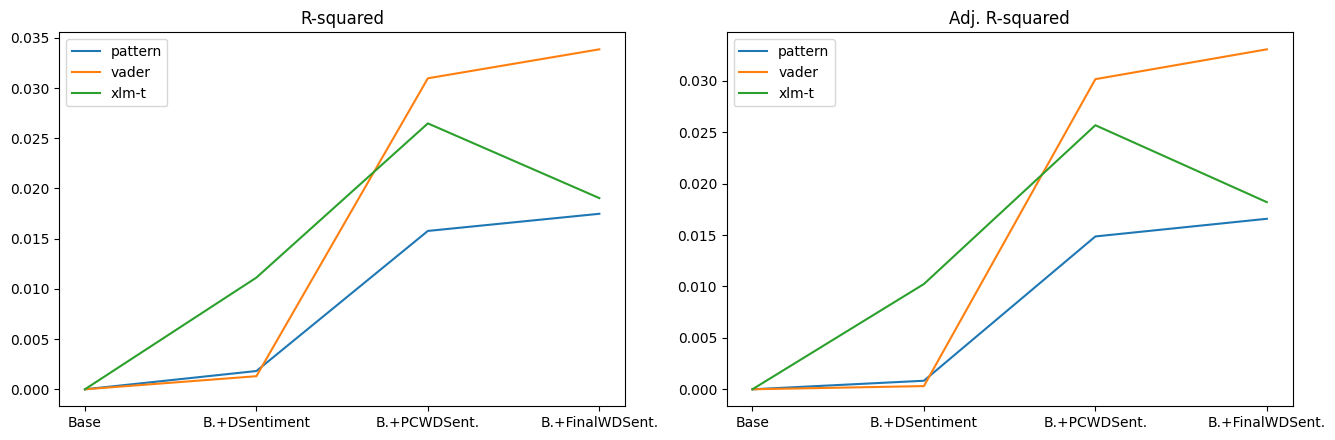

In [12]:
plot_rsquared(results, 0)

method   model   
vader    base        0.000000
         sent        0.000948
         sent+pc     0.009870
         fin_sent    0.011034
pattern  base        0.000000
         sent        0.000398
         sent+pc     0.005559
         fin_sent    0.006413
xlm-t    base        0.000000
         sent        0.002502
         sent+pc     0.013858
         fin_sent    0.017189
Name: mean, dtype: float64
method   model   
vader    base        0.000000
         sent       -0.000048
         sent+pc     0.008932
         fin_sent    0.010104
pattern  base        0.000000
         sent       -0.000601
         sent+pc     0.004593
         fin_sent    0.005453
xlm-t    base        0.000000
         sent        0.001557
         sent+pc     0.012984
         fin_sent    0.016337
Name: mean, dtype: float64


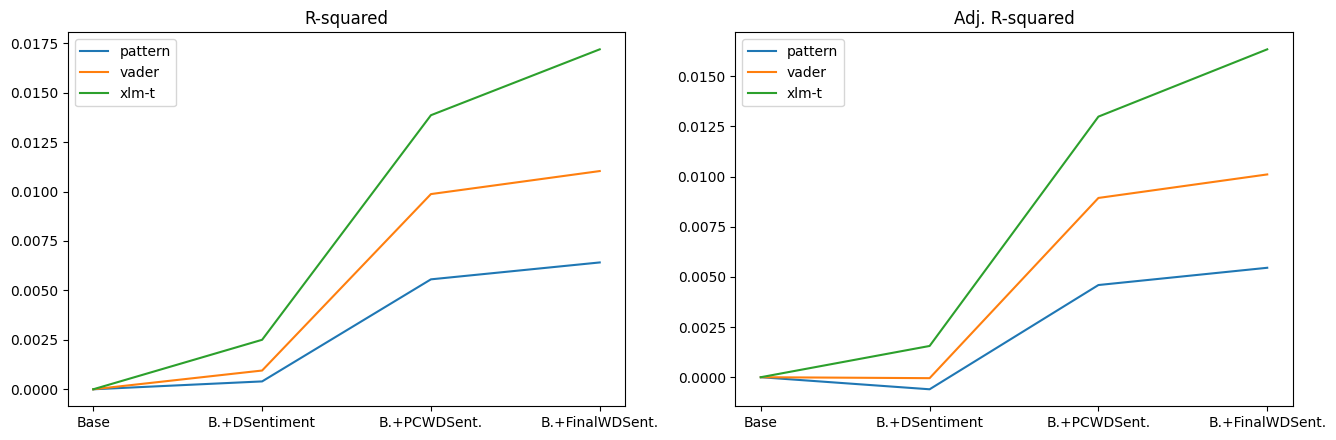

In [13]:
plot_rsquared(results, 1)

method   model   
vader    base        0.000000
         sent        0.000706
         sent+pc     0.005044
         fin_sent    0.004642
pattern  base        0.000000
         sent        0.000629
         sent+pc     0.004483
         fin_sent    0.004532
xlm-t    base        0.000000
         sent        0.001691
         sent+pc     0.001095
         fin_sent    0.001433
Name: mean, dtype: float64
method   model   
vader    base        0.000000
         sent       -0.000313
         sent+pc     0.004054
         fin_sent    0.003649
pattern  base        0.000000
         sent       -0.000390
         sent+pc     0.003489
         fin_sent    0.003538
xlm-t    base        0.000000
         sent        0.000736
         sent+pc     0.000136
         fin_sent    0.000476
Name: mean, dtype: float64


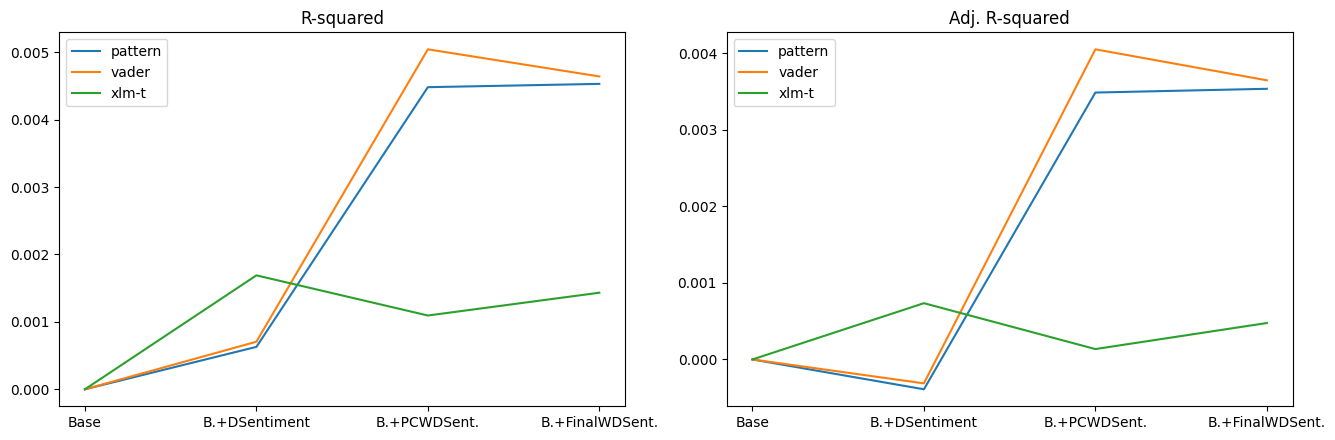

In [14]:
plot_rsquared(results, 2)

#### Print results

In [15]:
def format_sci(x):
    if 0 < abs(x) < 0.001:  # Check if the first non-zero digit starts at the third decimal place
        return "{:.2e}".format(x)
    else:
        return "{:.3f}".format(x)

In [16]:
results[0].applymap(format_sci)

aapl       gme       mcd      msft  \
method  model    results                                                  
vader   base     R-squared          0.661     0.095     0.424     0.777   
                 Adj. R-squared     0.660     0.093     0.423     0.776   
                 Coef.              0.000     0.000     0.000     0.000   
                 P>|t|              0.000     0.000     0.000     0.000   
        sent     R-squared          0.661     0.095     0.425     0.778   
                 Adj. R-squared     0.660     0.092     0.423     0.777   
                 Coef.              0.001     0.002     0.001     0.002   
                 P>|t|              0.265     0.829     0.266     0.079   
        sent+pc  R-squared          0.672     0.129     0.430     0.792   
                 Adj. R-squared     0.671     0.126     0.428     0.791   
                 Coef.           1.79e-04  4.89e-05  2.83e-04  2.52e-04   
                 P>|t|           7.68e-11  3.47e-10  2.98e-04  1.22e-20   
        fin_sent R-squared          0.672     0.135     0.429     0.790   
                 Adj. R-squared     0.671     0.132     0.427     0.789   
                 Coef.           1.56e-05  4.44e-06  2.30e-05  1.97e-05   
                 P>|t|           2.35e-10  1.12e-11     0.001  3.25e-18   
pattern base     R-squared          0.661     0.095     0.424     0.777   
                 Adj. R-squared     0.660     0.093     0.423     0.776   
                 Coef.              0.000     0.000     0.000     0.000   
                 P>|t|              0.000     0.000     0.000     0.000   
        sent     R-squared          0.661     0.096     0.424     0.777   
                 Adj. R-squared     0.660     0.092     0.422     0.776   
                 Coef.           6.87e-04     0.022    -0.002     0.003   
                 P>|t|              0.909     0.477     0.607     0.443   
        sent+pc  R-squared          0.663     0.103     0.425     0.789   
                 Adj. R-squared     0.662     0.100     0.423     0.788   
                 Coef.           3.64e-04  7.64e-05  4.78e-04     0.001   
                 P>|t|              0.010     0.003     0.123  4.19e-16   
        fin_sent R-squared          0.662     0.102     0.425     0.787   
                 Adj. R-squared     0.661     0.098     0.423     0.786   
                 Coef.           2.99e-05  5.91e-06  4.30e-05  9.08e-05   
                 P>|t|              0.020     0.006     0.141  3.81e-14   
xlm-t   base     R-squared          0.661     0.094     0.424     0.777   
                 Adj. R-squared     0.660     0.091     0.422     0.776   
                 Coef.              0.000     0.000     0.000     0.000   
                 P>|t|              0.000     0.000     0.000     0.000   
        sent     R-squared          0.663     0.101     0.429     0.779   
                 Adj. R-squared     0.662     0.097     0.427     0.779   
                 Coef.              0.009     0.044     0.007     0.007   
                 P>|t|              0.003     0.003  9.38e-04  1.27e-04   
        sent+pc  R-squared          0.665     0.094     0.426     0.778   
                 Adj. R-squared     0.664     0.091     0.424     0.778   
                 Coef.           2.96e-04  5.91e-06  4.36e-04  2.18e-04   
                 P>|t|           9.19e-05     0.562     0.023     0.003   
        fin_sent R-squared          0.661     0.094     0.426     0.777   
                 Adj. R-squared     0.660     0.091     0.424     0.776   
                 Coef.           5.38e-06  5.91e-07  3.57e-05  1.30e-08   
                 P>|t|              0.550     0.393     0.034     0.999   

                                      nflx      nvda      tsla      mean  
method  model    results                                                  
vader   base     R-squared           0.375     0.632     0.307     0.467  
                 Adj. R-squared      0.373     0.631     0.30

In [17]:
results[1].applymap(format_sci)

aapl        gme        mcd       msft  \
method  model    results                                                      
vader   base     R-squared           0.666      0.095      0.425      0.778   
                 Adj. R-squared      0.665      0.092      0.424      0.777   
                 Coef.               0.000      0.000      0.000      0.000   
                 P>|t|               0.000      0.000      0.000      0.000   
        sent     R-squared           0.667      0.095      0.425      0.778   
                 Adj. R-squared      0.666      0.091      0.423      0.778   
                 Coef.               0.003      0.002   1.18e-04      0.002   
                 P>|t|               0.018      0.756      0.904      0.067   
        sent+pc  R-squared           0.672      0.097      0.428      0.788   
                 Adj. R-squared      0.671      0.093      0.426      0.787   
                 Coef.            1.48e-04   1.21e-05   2.06e-04   2.06e-04   
                 P>|t|            5.92e-07      0.154      0.009   6.73e-14   
        fin_sent R-squared           0.674      0.096      0.428      0.787   
                 Adj. R-squared      0.673      0.093      0.427      0.786   
                 Coef.            1.49e-05   9.24e-07   1.90e-05   1.68e-05   
                 P>|t|            4.30e-08      0.196      0.008   2.72e-13   
pattern base     R-squared           0.666      0.095      0.425      0.778   
                 Adj. R-squared      0.665      0.092      0.424      0.777   
                 Coef.               0.000      0.000      0.000      0.000   
                 P>|t|               0.000      0.000      0.000      0.000   
        sent     R-squared           0.666      0.095      0.425      0.778   
                 Adj. R-squared      0.665      0.091      0.423      0.777   
                 Coef.           -4.24e-05     -0.009      0.001  -3.03e-04   
                 P>|t|               0.994      0.755      0.734      0.938   
        sent+pc  R-squared           0.669      0.097      0.427      0.785   
                 Adj. R-squared      0.667      0.094      0.425      0.784   
                 Coef.            4.91e-04   4.54e-05   6.82e-04   9.54e-04   
                 P>|t|               0.001      0.099      0.032   2.17e-10   
        fin_sent R-squared           0.670      0.098      0.428      0.785   
                 Adj. R-squared      0.669      0.094      0.426      0.785   
                 Coef.            6.27e-05   4.43e-06   7.74e-05   8.15e-05   
                 P>|t|            3.07e-05      0.056      0.010   6.90e-11   
xlm-t   base     R-squared           0.660      0.094      0.424      0.777   
                 Adj. R-squared      0.659      0.091      0.422      0.777   
                 Coef.               0.000      0.000      0.000      0.000   
                 P>|t|               0.000      0.000      0.000      0.000   
        sent     R-squared           0.661      0.096      0.425      0.778   
                 Adj. R-squared      0.660      0.092      0.423      0.778   
                 Coef.               0.005      0.022      0.004      0.004   
                 P>|t|               0.072      0.137      0.108      0.011   
        sent+pc  R-squared           0.660      0.105      0.424      0.777   
                 Adj. R-squared      0.659      0.102      0.422      0.777   
                 Coef.            1.06e-04  -3.83e-05   5.16e-06   7.03e-05   
                 P>|t|               0.201   2.45e-04      0.978      0.344   
        fin_sent R-squared           0.662      0.106      0.424      0.779   
                 Adj. R-squared      0.661      0.103      0.422      0.779   
                 Coef.           -2.56e-05  -2.73e-06  -1.21e-05  -2.62e-05   
                 P>|t|               0.009   1.13e-04      0.462   6.70e-04   

                                      nflx      nvda      tsla      mean  
method  mode

In [18]:
results[2].applymap(format_sci)

aapl        gme        mcd       msft  \
method  model    results                                                      
vader   base     R-squared           0.661      0.097      0.426      0.776   
                 Adj. R-squared      0.660      0.094      0.424      0.776   
                 Coef.               0.000      0.000      0.000      0.000   
                 P>|t|               0.000      0.000      0.000      0.000   
        sent     R-squared           0.662      0.097      0.427      0.776   
                 Adj. R-squared      0.661      0.093      0.425      0.776   
                 Coef.               0.002  -3.57e-04      0.001      0.001   
                 P>|t|               0.081      0.967      0.248      0.176   
        sent+pc  R-squared           0.662      0.099      0.427      0.785   
                 Adj. R-squared      0.661      0.095      0.426      0.784   
                 Coef.            6.49e-05  -1.21e-05   1.53e-04   2.02e-04   
                 P>|t|               0.032      0.151      0.070   1.55e-12   
        fin_sent R-squared           0.662      0.098      0.427      0.784   
                 Adj. R-squared      0.661      0.094      0.425      0.783   
                 Coef.            5.81e-06  -7.12e-07   1.01e-05   1.61e-05   
                 P>|t|               0.032      0.317      0.184   2.22e-11   
pattern base     R-squared           0.661      0.097      0.426      0.776   
                 Adj. R-squared      0.660      0.094      0.424      0.776   
                 Coef.               0.000      0.000      0.000      0.000   
                 P>|t|               0.000      0.000      0.000      0.000   
        sent     R-squared           0.661      0.097      0.427      0.776   
                 Adj. R-squared      0.660      0.093      0.425      0.776   
                 Coef.            3.75e-04     -0.010      0.007      0.005   
                 P>|t|               0.945      0.720      0.086      0.204   
        sent+pc  R-squared           0.661      0.100      0.429      0.783   
                 Adj. R-squared      0.660      0.096      0.427      0.782   
                 Coef.            5.64e-05  -5.63e-05   8.52e-04   9.73e-04   
                 P>|t|               0.717      0.075      0.013   3.86e-10   
        fin_sent R-squared           0.661      0.099      0.429      0.782   
                 Adj. R-squared      0.660      0.096      0.427      0.782   
                 Coef.            1.45e-05  -4.50e-06   8.67e-05   7.70e-05   
                 P>|t|               0.331      0.098      0.008   2.87e-09   
xlm-t   base     R-squared           0.662      0.095      0.424      0.777   
                 Adj. R-squared      0.661      0.093      0.423      0.777   
                 Coef.               0.000      0.000      0.000      0.000   
                 P>|t|               0.000      0.000      0.000      0.000   
        sent     R-squared           0.662      0.096      0.424      0.779   
                 Adj. R-squared      0.661      0.093      0.423      0.779   
                 Coef.               0.004      0.019   7.94e-04      0.005   
                 P>|t|               0.108      0.192      0.713   6.69e-04   
        sent+pc  R-squared           0.662      0.096      0.425      0.778   
                 Adj. R-squared      0.661      0.093      0.423      0.777   
                 Coef.            8.08e-05  -2.00e-05  -2.17e-04   1.24e-04   
                 P>|t|               0.246      0.285      0.261      0.132   
        fin_sent R-squared           0.662      0.096      0.425      0.779   
                 Adj. R-squared      0.661      0.092      0.423      0.779   
                 Coef.           -1.60e-05  -1.12e-06  -1.63e-05  -3.00e-05   
                 P>|t|               0.168      0.394      0.330   7.89e-04   

                                      nflx       nvda       tsla       mean  
method  m